In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [0]:
from torchfusion_utils.fp16 import convertToFP16
from torchfusion_utils.initializers import *
from torchfusion_utils.metrics import Accuracy
from torchfusion_utils.models import load_model,save_model

In [1]:
pip install torchfusion-utils

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/FIRE-SMOKE-DATASET.zip" -d "/content/drive/My Drive/"

In [0]:
data_dir = '/content/drive/My Drive/FIRE-SMOKE-DATASET/Train'
test_dir = '/content/drive/My Drive/FIRE-SMOKE-DATASET/Test'

In [6]:

def load_split_train_test(datadir,testdir):
    train_transforms = transforms.Compose([transforms.Resize((224,224),0),
                                       transforms.ToTensor(),
                                       ])
    transforms_test = transforms.Compose([transforms.Resize((224,224),0),
                                       transforms.ToTensor()])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(testdir,       
                    transform=transforms_test)
    num_train = len(train_data)
    print(num_train)
    indices = list(range(num_train))
    trainloader = torch.utils.data.DataLoader(train_data,
                   shuffle = True, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64,shuffle = True)  #shuffle = True
    
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, test_dir)

print(trainloader.dataset.classes)


2700
['Fire', 'Neutral', 'Smoke']


In [0]:
ResNet = models.resnet50(num_classes=3)

In [0]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda', index=0)

In [0]:
Model = ResNet 

Model = Model.to(device)

lr = 0.001

criteria = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(Model.parameters(), lr=lr)

Model,optimizer = convertToFP16(Model, optimizer)

milestones = [20, 50,100,150]

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
class_names = ['Fire','Neutral','Smoke']

In [0]:
epochs = 200
steps = 0
running_loss = 0
train_losses,test_losses = [],[]
p = []
t= []

In [0]:
def model_traing_and_validation_loop(Model, n_epochs, save_path):
    
    n_epochs = n_epochs

    saving_criteria_of_model = 0

    training_loss_array = []

    validation_loss_array = []
    
    train_acc = Accuracy()
    
    validation_acc = Accuracy(topK=1)
    

    for i in range(n_epochs):
        print(i,"th epoch")

        p = []
        t = []

        total_test_data = 0

        total_train_data = 0

        correct_test_data = 0

        training_loss = 0

        validation_loss = 0
        
        train_acc.reset()

        for data, target in trainloader:

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            predictions = Model(data)
            p.append(predictions)
            t.append(target)

            loss = criteria(predictions, target)
            
            optimizer.backward(loss)

            optimizer.step()

            training_loss += loss.item()*data.size(0)

            train_acc.update(predictions, target)
            
        scheduler.step()

        with torch.no_grad():
            
            validation_acc.reset()
            
            for data, target in testloader:
                #print("target",target)

                data, target = data.to(device,dtype=torch.float), target.to(device,dtype=torch.float)


                
                data = data.float()
                target = target.long()
                data, target = Variable(data), Variable(target)



                predictions = Model(data)
                
                loss = criteria(predictions, target)
                
                validation_acc.update(predictions, target)
                
                total_test_data += target.size(0)

                validation_loss += loss.item()*data.size(0)
                
                
        training_loss = training_loss / 2700
        
        validation_loss = validation_loss / total_test_data

        training_loss_array.append(training_loss)
        
        validation_loss_array.append(validation_loss)
        
        #tf.cpu() 
        
        predictions = torch.argmax(predictions, 1)  #this needs gpu

        predictions = predictions.cpu()
        predictions = predictions.numpy()
        
        ground_truth = target.cpu().numpy()
        pred = predictions
        l = len(pred)
        ground_truth = target.cpu().numpy()
        ground_truth = np.array(ground_truth)    
        pred = np.array(predictions)

        print("gt", ground_truth)
        print("pred",pred)
        
      
        
      

        print(f'{i+1} / {n_epochs} Training loss: {training_loss}, Tran_Accuracy: {train_acc.getValue()}, Validation_loss: {validation_loss}, Validation_Accuracy: {validation_acc.getValue()}')
        if i in [0,5,8,9,12,14,15,19,21,39,49,99,149,199]:
          print(classification_report(ground_truth,pred,target_names=class_names))
          #print()
          #print(confusion_matrix(ground_truth,pred, class_names))

        if saving_criteria_of_model < validation_acc.getValue():

            torch.save(Model, save_path)
            
            saving_criteria_of_model = validation_acc.getValue()
            
            print('--------------------------Saving Model---------------------------')
    
    plt.figure(figsize=(20, 4))
        
    x_axis = (range(n_epochs))
        
    plt.plot(x_axis, training_loss_array, 'r', validation_loss_array, 'b')
        
    plt.title('A graph of training loss vs validation loss')
        
    plt.legend(['train loss', 'validation loss'])
        
    plt.xlabel('Number of Epochs')
        
    plt.ylabel('Loss')
        
    return Model,p,t
        




0 th epoch
gt [2 1 2 1 1 2 2 2 1 2 1 2 1 2 2 0 0 1 0 2 2 1 2 2 1 0 2 0 2 1 0 1 1 1 0 2 1
 0 0 0 0 1 0 1]
pred [2 1 1 1 0 2 2 1 1 0 1 0 1 2 0 2 0 1 0 0 1 1 1 2 1 0 2 0 2 1 0 1 1 0 0 2 0
 1 0 0 0 1 0 2]
1 / 30 Training loss: 1.0834291811342593, Tran_Accuracy: 0.46666666865348816, Validation_loss: 0.6921875, Validation_Accuracy: 0.7099999785423279
              precision    recall  f1-score   support

        Fire       0.59      0.83      0.69        12
     Neutral       0.71      0.75      0.73        16
       Smoke       0.80      0.50      0.62        16

    accuracy                           0.68        44
   macro avg       0.70      0.69      0.68        44
weighted avg       0.71      0.68      0.68        44

--------------------------Saving Model---------------------------
1 th epoch
gt [2 2 0 1 1 2 1 2 2 2 2 1 2 2 1 1 0 0 0 2 0 2 0 1 1 2 0 2 0 1 0 0 2 1 1 1 2
 2 1 0 2 0 1 1]
pred [2 2 0 1 0 2 1 2 1 1 2 1 1 2 1 1 0 0 0 1 0 2 0 1 1 2 0 2 0 1 0 1 1 1 1 1 2
 1 1 0 1 0 1 1]
2 / 3

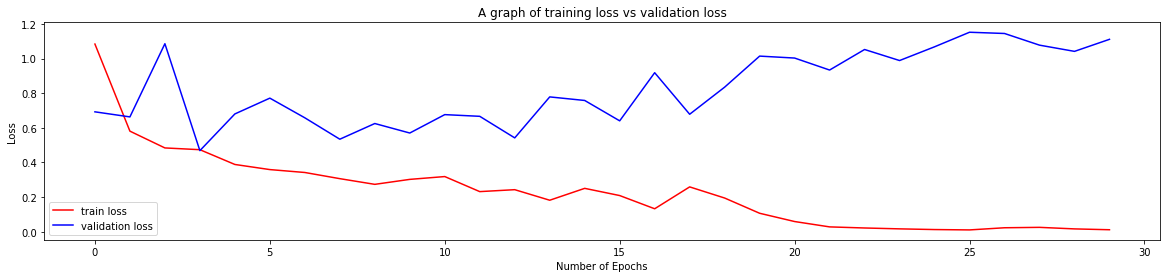

In [14]:
n_epochs = 30
model,p,t = model_traing_and_validation_loop(Model, n_epochs, 'fire-flame.pt')

In [0]:
p = []
g = []
for i in range(1):

for data, target in testloader:

                #print("target",target)

  data, target = data.to(device,dtype=torch.float), target.to(device,dtype=torch.float)


                
  data = data.float()
  target = target.long()
  data, target = Variable(data), Variable(target)



  predictions = Model(data)
                
                
                loss = criteria(predictions, target)
                
                validation_acc.update(predictions, target)
                
                total_test_data += target.size(0)

                validation_loss += loss.item()*data.size(0)
                
                
        training_loss = training_loss / 2700
        
        validation_loss = validation_loss / total_test_data

        training_loss_array.append(training_loss)
        
        validation_loss_array.append(validation_loss)
        
        #tf.cpu() 
        
        predictions = torch.argmax(predictions, 1)  #this needs gpu
       

        predictions = predictions.cpu()
        predictions = predictions.numpy()
        p.append(predictions)
        
        ground_truth = target.cpu().numpy()
        g.append(ground_truth)
        pred = predictions
        l = len(pred)
        ground_truth = target.cpu().numpy()
        ground_truth = np.array(ground_truth)    
        pred = np.array(predictions)

0 th epoch
gt [2 2 2 2 0 0 0 1 0 0 2 2 1 1 2 2 2 2 2 1 2 0 2 2 1 0 2 1 1 2 0 2 1 0 2 2 2
 1 2 2 0 1 1 2]
pred [2 2 2 2 1 0 0 2 0 2 1 2 1 1 2 2 2 1 2 1 2 0 2 2 1 0 2 1 1 2 0 2 1 1 1 1 2
 1 2 2 0 1 1 2]
['Fire', 'Neutral', 'Smoke']
1 / 50 Training loss: 0.25591869212962964, Tran_Accuracy: 0.9055555462837219, Validation_loss: 0.7105598958333333, Validation_Accuracy: 0.7666666507720947
              precision    recall  f1-score   support

        Fire       1.00      0.70      0.82        10
     Neutral       0.62      0.91      0.74        11
       Smoke       0.90      0.83      0.86        23

    accuracy                           0.82        44
   macro avg       0.84      0.81      0.81        44
weighted avg       0.86      0.82      0.82        44


--------------------------Saving Model---------------------------
1 th epoch
gt [2 1 1 1 1 2 2 2 0 0 0 1 2 0 0 0 0 1 0 1 0 1 0 2 1 0 1 0 1 0 0 1 0 2 0 1 0
 0 2 2 2 0 1 1]
pred [2 1 1 1 2 2 2 2 0 0 0 1 2 0 2 0 0 1 0 1 0 1 0 2 1 0 1 0 

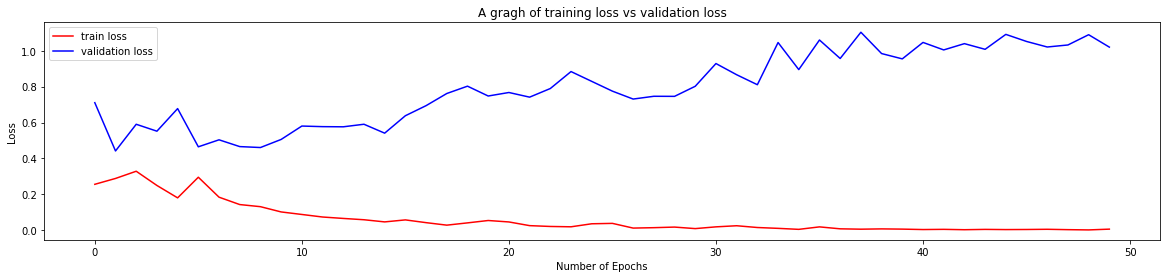

In [0]:
#import tensorflow as tf
n_epochs = 50
model,p,t = model_traing_and_validation_loop(Model, n_epochs, 'fire-flame.pt')

In [0]:
# for 20 epochs start @ 11:04 pm  ends @ 11:20 pm

In [0]:
# for 50 epochs start @ 10:46 @11:59

In [0]:
# for 200 epochs start @7:07

0 th epoch
gt [1 2 1 0 0 0 1 2 2 2 2 2 0 1 1 2 2 2 1 0 0 2 2 1 0 0 2 1 1 0 0 2 1 1 0 0 0
 0 2 1 0 1 0 2]
pred [0 2 1 0 0 2 1 1 1 2 2 2 0 1 1 0 2 2 2 0 0 2 2 2 0 1 2 2 2 1 0 2 1 0 0 0 0
 0 2 2 1 1 2 2]
1 / 200 Training loss: 0.9309541377314815, Tran_Accuracy: 0.652222216129303, Validation_loss: 0.713828125, Validation_Accuracy: 0.6966666579246521
              precision    recall  f1-score   support

        Fire       0.79      0.69      0.73        16
     Neutral       0.55      0.46      0.50        13
       Smoke       0.63      0.80      0.71        15

    accuracy                           0.66        44
   macro avg       0.65      0.65      0.65        44
weighted avg       0.66      0.66      0.66        44

--------------------------Saving Model---------------------------
1 th epoch
gt [0 2 2 2 2 2 2 0 1 2 2 0 2 2 0 2 1 1 0 0 2 0 0 1 0 2 2 0 0 1 1 1 2 1 0 2 2
 0 1 1 2 0 0 2]
pred [0 1 2 1 2 1 2 0 1 2 1 0 2 0 0 2 1 1 0 0 2 0 0 1 0 1 2 0 0 1 1 1 2 1 0 1 1
 0 1 1 2 0 0 1]
2 / 

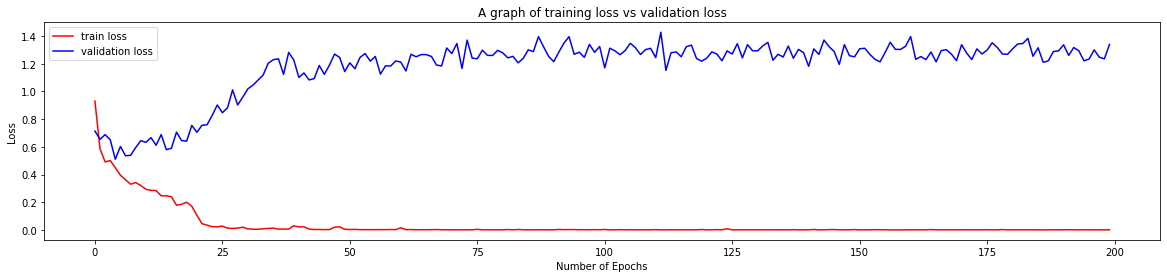

In [0]:
n_epochs = 200
model,p,t = model_traing_and_validation_loop(Model, n_epochs, 'fire-flame.pt')

0 th epoch
gt [0 1 1 1 1 1 2 0 2 0 2 0 0 0 2 1 1 0 2 1 2 0 1 1 0 0 0 2 1 0 2 1 2 0 0 2 0
 1 2 2 0 1 0 2 0 0 2 0 1 2 2 2 1 0 1 2 2 1 0 2]
pred [2 1 1 0 1 1 2 0 2 0 2 0 0 0 1 2 1 0 2 2 2 0 1 0 0 0 0 2 1 0 2 1 2 0 1 2 0
 1 1 2 0 1 2 1 0 2 2 2 1 1 2 2 1 0 1 1 2 1 0 2]
1 / 50 Training loss: 0.001591067843967014, Tran_Accuracy: 1.0, Validation_loss: 1.0796875, Validation_Accuracy: 0.8233333230018616
              precision    recall  f1-score   support

        Fire       0.89      0.77      0.83        22
     Neutral       0.70      0.78      0.74        18
       Smoke       0.71      0.75      0.73        20

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.78      0.77      0.77        60

--------------------------Saving Model---------------------------
1 th epoch
gt [2 1 0 0 1 1 1 0 0 1 1 1 2 2 2 1 2 2 2 2 0 0 1 1 0 2 2 1 0 2 0 0 1 1 2 1 0
 1 2 2 0 1 2 0 2 1 1 2 1 1 0 0 1 1 1 0 0 1 0 2]
pred [2 2 0 0 1 1 1

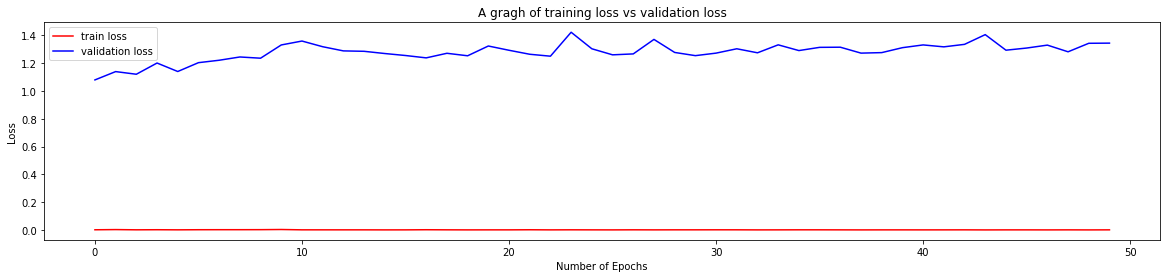

In [0]:
# batch = 120 trial
n_epochs = 50
model,p,t = model_traing_and_validation_loop(Model, n_epochs, 'fire-flame.pt')

In [0]:
load_saved_model = torch.load('fire-flame.pt')

FileNotFoundError: ignored

In [0]:
model.eval()

MultiSequential(
  (0): Convert()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [0]:
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [0]:
p = []
for data, target in testloader:
    data, target = data.to(device,dtype=torch.float), target.to(device)


                
    data = data.float()
    target = target.long()
    data, target = Variable(data), Variable(target)



    predictions = load_saved_model(data)
    p.append(predictions)

RuntimeError: ignored

In [0]:
from keras.preprocessing import image  

img = image.load_img(img_path, target_size=(224, 224))

In [0]:
def load_split_test(testdir):
    
    transforms_test = transforms.Compose([transforms.Resize((224,224),0),
                                       transforms.ToTensor()])
    test_data = datasets.ImageFolder(testdir,       
                    transform=transforms_test)
        
    test = torch.utils.data.DataLoader(test_data, shuffle=True)
    
    return test
test= load_split_test(test_dir)

In [0]:
p = []
for data, target in testloader:
    #            
    data = data.float()
    target = target.long()
    data, target = Variable(data), Variable(target)



    predictions = load_saved_model(data)
    p.append(predictions)

RuntimeError: ignored

In [0]:
n_epochs = 50
model = model_traing_and_validation_loop(Model, n_epochs, 'fire-flame.pt')

0 th epoch


RuntimeError: ignored